# The *Excel scan* plan

Use a spreadsheet as a multi-sample batch scan tool.  
We'll need a spreadsheet with some things to be done 
and a plan that will read that spreadsheet and act on it. 

This plan will:

* [x] use an Excel spreadsheet (for starters)
* [x] read a table from the spreadsheet file
* [x] take a single action from each row in the table
* [x] decide action based on a specific named column in the table
* [x] report all columns as metadata for the action
* [x] ignore empty rows
* [ ] ignore any data outside of the table boundaries

Since the actions and parameters (args & kwargs) will be 
different in every implementation, this may prove difficult 
to generalize.

Here's the demo, starting with the bluesky setup.

In [1]:
# Import matplotlib and put it in interactive mode.
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

import os
import sys
import time

from databroker import Broker
db = Broker.named("mongodb_config")

from bluesky import RunEngine
import bluesky.plans as bp
import bluesky.plan_stubs as bps
from bluesky.callbacks.best_effort import BestEffortCallback
from bluesky import SupplementalData
from bluesky.simulators import summarize_plan
from bluesky.suspenders import SuspendFloor

from ophyd.sim import motor1, motor2, motor3, SynGauss

import apstools.devices as APS_devices
import apstools.utils as APS_utils

RE = RunEngine({})
RE.subscribe(db.insert)
RE.subscribe(BestEffortCallback())
RE.preprocessors.append(SupplementalData())

shutter = APS_devices.SimulatedApsPssShutterWithStatus(name="shutter")
watch_for_shutter_close = SuspendFloor(shutter.pss_state, 1)

noisy_det = SynGauss('noisy_det', motor1, 'motor1', center=0, Imax=1,
                noise='uniform', sigma=0.9, noise_multiplier=0.1, labels={'detectors'})
noisy_det.kind = "hinted"

----

## Excel plan and infrastructure

In [2]:
def beforeExcelPlan():
    """things to be done at the start of every Excel plan"""
    yield from bps.mv(
        shutter, "open",    # for example
    )

    
def afterExcelPlan():
    """things to be done at the end of every Excel plan"""
    yield from bps.mv(
        shutter, "close",   # for example
        motor1, 0,              # park the motors
        motor2, 0,
        motor3, 0,
    )


def step_scan(pos_X, pos_Y, thickness, scan_title, md={}):
    """
    collect some data with a step scan
    """
    yield from bps.mv(
        motor2, pos_X,
        motor3, pos_Y,
    )
    md[motor2.name] = motor2.position
    md[motor3.name] = motor3.position
    md["shutter"] = shutter.state
    for k, v in md.items():
        print(f"{k}: {v}")

    yield from bps.install_suspender(watch_for_shutter_close)
    yield from bp.scan([noisy_det], motor1, -5, 5, 8, md=md)
    yield from bps.remove_suspender(watch_for_shutter_close)


def Excel_plan(xl_file):
    """
    example of reading a list of samples from Excel spreadsheet
    
    USAGE::
    
        summarize_plan(run_Excel_file("sample_example.xlsx"))
        RE(run_Excel_file("sample_example.xlsx"))
    """
    assert os.path.exists(xl_file)
    xl = APS_utils.ExcelDatabaseFileGeneric(os.path.abspath(xl_file))

    yield from beforeExcelPlan()
    for i, row in enumerate(xl.db.values()):
        # print(f"row={row}")
        scan_command = (row["Scan Type"] or "").lower()
        if scan_command == "step_scan":
            _md = {APS_utils.cleanupText(k): v for k, v in row.items()}
            _md["table_row"] = i+1
            yield from step_scan(
                row["sx"],  # label must match cell string EXACTLY
                row["sy"], 
                row["Thickness"], 
                row["Sample Name"],
                # add all input as scan metadata, ensure the keys are clean
                md=_md,
                )
        else:
            print(f"no handling for table row {i+1}: {row}")
    yield from afterExcelPlan()


summarize_plan(Excel_plan("sample_example.xlsx"))

shutter -> open
motor2 -> 5.07
motor3 -> 8.3
Scan_Type: step_scan
sx: 5.07
sy: 8.3
Thickness: 0
Sample_Name: Water Blank
remarks: deionized
code_number: None
table_row: 1
motor2: 0
motor3: 0
shutter: close
=================================== Open Run ===================================
motor1 -> -5.0
  Read ['noisy_det', 'motor1']
motor1 -> -3.571428571428571
  Read ['noisy_det', 'motor1']
motor1 -> -2.142857142857143
  Read ['noisy_det', 'motor1']
motor1 -> -0.7142857142857144
  Read ['noisy_det', 'motor1']
motor1 -> 0.7142857142857144
  Read ['noisy_det', 'motor1']
motor1 -> 2.1428571428571432
  Read ['noisy_det', 'motor1']
motor1 -> 3.571428571428571
  Read ['noisy_det', 'motor1']
motor1 -> 5.0
  Read ['noisy_det', 'motor1']
================================== Close Run ===================================
no handling for table row 2: {'Scan Type': 'other_scan', 'sx': 5.07, 'sy': 8.3, 'Thickness': 0, 'Sample Name': 'Water Blank', 'remarks': 'deionized', 'code number': None}
no handlin

Scan_Type: step_scan
sx: 5.07
sy: 8.3
Thickness: 0
Sample_Name: Water Blank
remarks: deionized
code_number: None
table_row: 1
motor2: 5.07
motor3: 8.3
shutter: open
Transient Scan ID: 1     Time: 2019-04-11 16:07:32
Persistent Unique Scan ID: '88c928a4-08af-4fba-95c6-b98956e94f07'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |     motor1 |  noisy_det |
+-----------+------------+------------+------------+


<IPython.core.display.Javascript object>


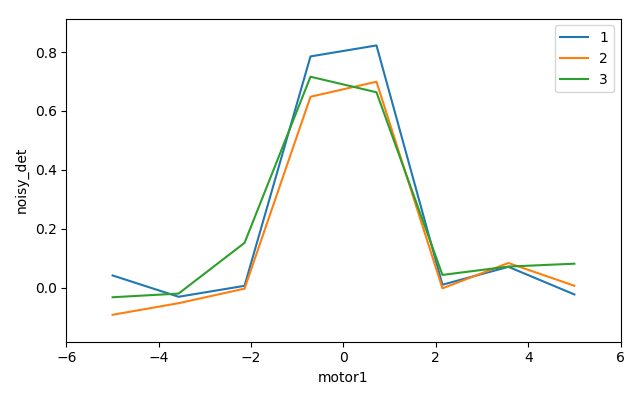

|         1 | 16:07:33.2 |     -5.000 |      0.042 |
|         2 | 16:07:33.2 |     -3.571 |     -0.031 |
|         3 | 16:07:33.2 |     -2.143 |      0.007 |
|         4 | 16:07:33.3 |     -0.714 |      0.785 |
|         5 | 16:07:33.3 |      0.714 |      0.823 |
|         6 | 16:07:33.3 |      2.143 |      0.010 |
|         7 | 16:07:33.3 |      3.571 |      0.071 |
|         8 | 16:07:33.3 |      5.000 |     -0.023 |
+-----------+------------+------------+------------+
generator scan ['88c928a4'] (scan num: 1)



no handling for table row 2: {'Scan Type': 'other_scan', 'sx': 5.07, 'sy': 8.3, 'Thickness': 0, 'Sample Name': 'Water Blank', 'remarks': 'deionized', 'code number': None}
no handling for table row 3: {'Scan Type': 'this will be ignored (and also the next blank row will be ignored)', 'sx': None, 'sy': None, 'Thickness': None, 'Sample Name': None, 'remarks': None, 'code number': None}
no handling for table row 4: {'Scan Type': None, 'sx': None, 'sy': None, 'Thickness': None, 

('88c928a4-08af-4fba-95c6-b98956e94f07',
 'cf034c49-8dc6-4f46-ae8d-fd328dcab8ed',
 '3d48254d-4341-4aeb-b87e-9c35b1564e9a')

In [3]:
RE(Excel_plan("sample_example.xlsx"))

In [4]:
noisy_det.hints["fields"] = noisy_det.name

In [5]:
noisy_det.kind = "hinted"
noisy_det.hints

{'fields': ['noisy_det']}